In [1]:
import sagemaker

In [11]:
from sagemaker import get_execution_role
from sagemaker.session import Session

In [12]:
role = get_execution_role()
bucket = Session().default_bucket()

In [13]:
import numpy as np
import pandas as pd
import pickle,gzip,numpy,boto3,json

In [14]:
%%time

# load data
region = boto3.Session().region_name
boto3.Session().resource('s3', region_name=region).Bucket('sagemaker-sample-data-{}'.format(region)).download_file('algorithms/kmeans/mnist/mnist.pkl.gz', 'mnist.pkl.gz')
with gzip.open('mnist.pkl.gz','rb') as f:
    train_set,valid_set,test_set = pickle.load(f,encoding='latin1')

CPU times: user 860 ms, sys: 449 ms, total: 1.31 s
Wall time: 2.48 s


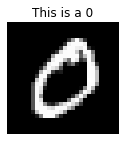

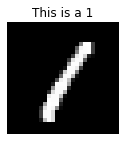

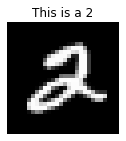

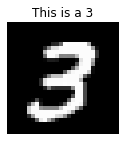

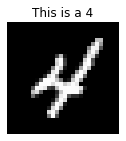

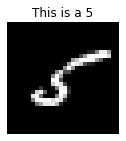

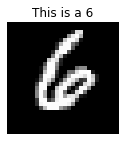

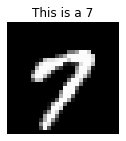

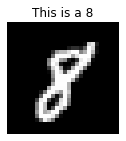

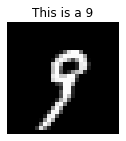

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (2,10)

def show_digit(img,caption='', subplot = None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

k = 0
for n in range(0,10):
    while not train_set[1][k]==n:
        k += 1
    show_digit(train_set[0][k], 'This is a {}'.format(train_set[1][k]))

## ^This is a ubiquitous dataset. Nothing special going on here

In [19]:
%%time
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket,data_key)
print('training data will be uploaded to : {}'.format(data_location))

#preprocess data to feed into model
buf = io.BytesIO()
write_numpy_to_dense_tensor(buf, train_set[0],train_set[1])
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)

training data will be uploaded to : s3://sagemaker-us-east-1-272114617779/kmeans_lowlevel_example/data
CPU times: user 9.06 s, sys: 281 ms, total: 9.34 s
Wall time: 10.7 s


In [28]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'kmeans-lowlevel-' + strftime('%Y-%m-%d-%H-%M-%S', gmtime())
print('training job name: ', job_name)

from sagemaker.amazon.amazon_estimator import get_image_uri
image = get_image_uri(boto3.Session().region_name, 'kmeans')

output_location = 's3://{}/kmeans_example/output'.format(bucket)
print('training artifacts will be uploaded to : {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        'TrainingImage': image,
        'TrainingInputMode': 'File'
    },
    'RoleArn': role,
    'OutputDataConfig': {
        'S3OutputPath': output_location
    },
    'ResourceConfig': {
        'InstanceCount': 2,
        'InstanceType': 'ml.c4.xlarge',
        'VolumeSizeInGB': 50
    },
    'TrainingJobName': job_name,
    'HyperParameters': {
        'k': '10',
        'feature_dim': '784',
        'mini_batch_size':'500',
        'force_dense': 'True'
    },
    'StoppingCondition':{
        'MaxRuntimeInSeconds': 60*60
    },
    'InputDataConfig':[
        {
            'ChannelName': 'train',
            'DataSource': {
                'S3DataSource':{
                    'S3DataType': 'S3Prefix',
                    'S3Uri': data_location,
                    'S3DataDistributionType':'FullyReplicated'
                }
            },
            'CompressionType':'None',
            'RecordWrapperType': 'None'
        }
    ]
}

sagemaker = boto3.client('sagemaker')
sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName = job_name)['TrainingJobStatus']

print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training {} failed with the following error: {}'.format(job_name,message))
        raise Exception('Training {} failed with the following error: {}'.format(job_name,message))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


training job name:  kmeans-lowlevel-2020-10-31-19-37-06
training artifacts will be uploaded to : s3://sagemaker-us-east-1-272114617779/kmeans_example/output
InProgress
Training job ended with status: Completed
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 6min


In [29]:
%%time
import boto3
from time import gmtime, strftime

model_name = job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image' : image,
    'ModelDataUrl' : model_data
}

create_model_response = sagemaker.create_model(ModelName = model_name, ExecutionRoleArn=role,PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

kmeans-lowlevel-2020-10-31-19-37-06
arn:aws:sagemaker:us-east-1:272114617779:model/kmeans-lowlevel-2020-10-31-19-37-06
CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 410 ms


In [32]:
endpoint_config_name = 'KMeansEndpointConfig-' + strftime('%Y-%m-%d-%H-%M-%S', gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])

print('endpoint config arn:' + create_endpoint_config_response['EndpointConfigArn'])


KMeansEndpointConfig-2020-10-31-19-49-18
endpoint config arn:arn:aws:sagemaker:us-east-1:272114617779:endpoint-config/kmeansendpointconfig-2020-10-31-19-49-18


In [35]:
%%time

endpoint_name = 'KMeansEndpoint-'+ strftime('%Y-%m-%d-%H-%M-%S',gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName = endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName = endpoint_name)
status = resp['EndpointStatus']
print('Status:' + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName = endpoint_name)
    status = resp['EndpointStatus']
    print('arn:' + resp['EndpointArn'])
    print('Create ednpoint edned with status' + status)
    
    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName = endpoint_name)['FailureReason']
        print(message)
        raise Exception('endpoint creation failed')

KMeansEndpoint-2020-10-31-21-06-41
arn:aws:sagemaker:us-east-1:272114617779:endpoint/kmeansendpoint-2020-10-31-21-06-41
Status:Creating
arn:arn:aws:sagemaker:us-east-1:272114617779:endpoint/kmeansendpoint-2020-10-31-21-06-41
Create ednpoint edned with statusInService
CPU times: user 279 ms, sys: 27.7 ms, total: 307 ms
Wall time: 8min 33s


In [36]:
# generating classification prediction from the trained model using the endpoint above

def np2csv(arr):
    csv = io.BytesIO()
    numpy.savetxt(csv, arr, delimiter = ',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [37]:
runtime = boto3.Session().client('runtime.sagemaker')

In [38]:
import json
payload = np2csv(train_set[0][30:31])

response = runtime.invoke_endpoint(EndpointName= endpoint_name,
                                  ContentType = 'text/csv',
                                  Body = payload)
result = json.loads(response['Body'].read().decode())
print(result)

{'predictions': [{'distance_to_cluster': 7.436732769012451, 'closest_cluster': 3.0}]}





Cluster0:


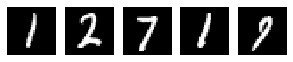




Cluster1:


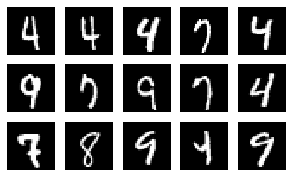




Cluster2:


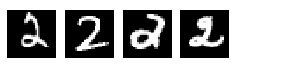




Cluster3:


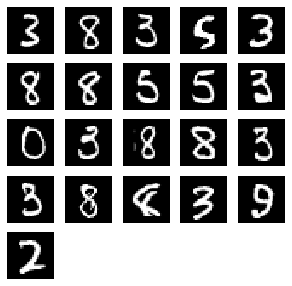




Cluster4:


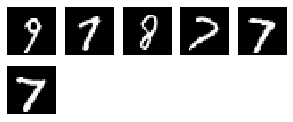




Cluster5:


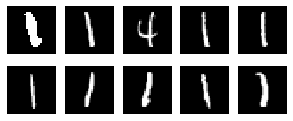




Cluster6:


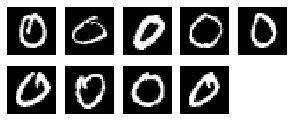




Cluster7:


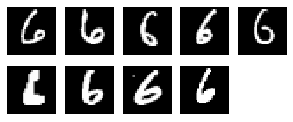




Cluster8:


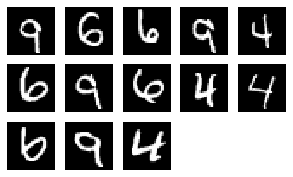




Cluster9:


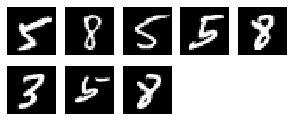

CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 4.63 s


In [39]:
%%time
payload = np2csv(valid_set[0][0:100])
response = runtime.invoke_endpoint(EndpointName= endpoint_name,
                                  ContentType= 'text/csv',
                                  Body= payload)
result = json.loads(response['Body'].read().decode())
clusters = [p['closest_cluster'] for p in result['predictions']]

for cluster in range(10):
    print('\n\n\nCluster{}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster  ]
    height=((len(digits)-1)//5)+1
    width = 5
    plt.rcParams['figure.figsize'] = (width,height)
    _, subplots = plt.subplots(height,width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot = subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')
        
    plt.show()